In this notebook we will look how we can use Cython to generate a faster callback and hopefully shave off some running time from our integration.

In [1]:
import json
import numpy as np
from scipy2017codegen.odesys import ODEsys
from scipy2017codegen.chem import mk_rsys

The `ODEsys` class and convenience functions from previous notebook (35) has been put in two modules for easy importing. Recapping what we did last:

In [2]:
watrad_data = json.load(open('../scipy2017codegen/data/radiolysis_300_Gy_s.json'))
watrad = mk_rsys(ODEsys, **watrad_data)
tout = np.logspace(-6, 3, 200)  # close to one hour of operation
c0 = {'H2O': 55.4e3, 'H+': 1e-4, 'OH-': 1e-4}
y0 = [c0.get(symb.name, 0) for symb in watrad.y]

In [3]:
%timeit yout, info = watrad.integrate_odeint(tout, y0)

4.31 s ± 531 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


so that is the benchmark to beat, we will export our expressions as Cython code. We then subclass `ODEsys` to have it render, compile and import the code:

In [4]:
# %load ../scipy2017codegen/odesys_cython.py
import uuid
import numpy as np
import sympy as sym
import setuptools
import pyximport
from scipy2017codegen import templates
from scipy2017codegen.odesys import ODEsys

pyximport.install()

cython_template = """
cimport numpy as cnp
import numpy as np

def f(cnp.ndarray[cnp.float64_t, ndim=1] y, double t, %(args)s):
    cdef cnp.ndarray[cnp.float64_t, ndim=1] out = np.empty(y.size)
    %(f_exprs)s
    return out

def j(cnp.ndarray[cnp.float64_t, ndim=1] y, double t, %(args)s):
    cdef cnp.ndarray[cnp.float64_t, ndim=2] out = np.empty((y.size, y.size))
    %(j_exprs)s
    return out

"""

class CythonODEsys(ODEsys):

    def setup(self):
        self.mod_name = 'ode_cython_%s' % uuid.uuid4().hex[:10]
        idxs = list(range(len(self.f)))
        subs = {s: sym.Symbol('y[%d]' % i) for i, s in enumerate(self.y)}
        f_exprs = ['out[%d] = %s' % (i, str(self.f[i].xreplace(subs))) for i in idxs]
        j_exprs = ['out[%d, %d] = %s' % (ri, ci, self.j[ri, ci].xreplace(subs)) for ri in idxs for ci in idxs]
        ctx = dict(
            args=', '.join(map(str, self.p)),
            f_exprs = '\n    '.join(f_exprs),
            j_exprs = '\n    '.join(j_exprs),
        )
        open('%s.pyx' % self.mod_name, 'wt').write(cython_template % ctx)
        open('%s.pyxbld' % self.mod_name, 'wt').write(templates.pyxbld % dict(
            sources=[], include_dirs=[np.get_include()],
            library_dirs=[], libraries=[], extra_compile_args=[], extra_link_args=[]
        ))
        mod = __import__(self.mod_name)
        self.f_eval = mod.f
        self.j_eval = mod.j


In [5]:
cython_sys = mk_rsys(CythonODEsys, **watrad_data)

In [6]:
%timeit cython_sys.integrate(tout, y0)

3.6 s ± 361 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That is a considerable speed up from before. But the solver still has to
allocate memory for creating new arrays at each call, and each evaluation
has to pass the python layer which is now the bottleneck for the integration.

In order to speed up integration further we need to make sure the solver can evaluate the function and Jacobian without calling into Python.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

Just to see that everything looks alright:

The rhs was evaluated 716 times and the jacobian 73 times


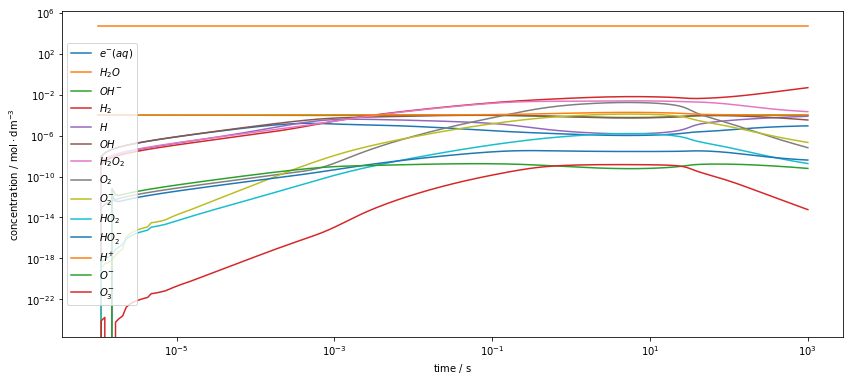

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
cython_sys.plot_result(tout, *cython_sys.integrate_odeint(tout, y0), ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')